# Shor's factoring algorithm

### Import section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

from qiskit import *
from qiskit_aer import QasmSimulator, UnitarySimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import *

print("Imports Successful")

Imports Successful


### Plot the function $f(x)=a^x {\rm mod} N$
#### $a$ and $N$ are positive integers with no common factors, $a<N$

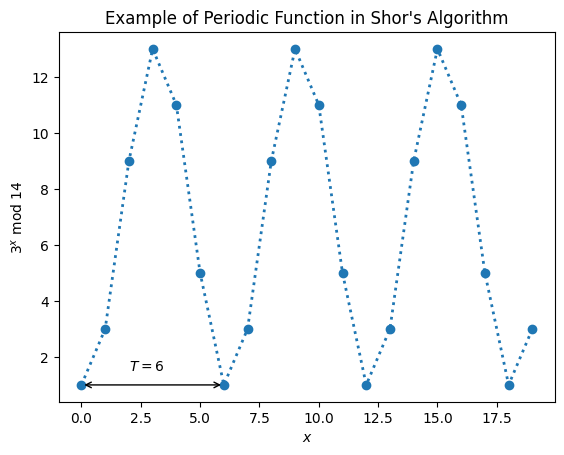

In [2]:
N = 14
a = 3

xv = np.arange(20)
yv = [np.mod(a**x, N) for x in xv]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xv, yv, linewidth=2, linestyle='dotted', marker='o')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot T on the graph
    T = yv[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(T,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$T=%i$' % T, xy=(T/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

## Factoring algorithm

### We provide an example to factorize 15 (not really the product of very large primes!)

#### Hence we choose $N=15$ and choose a random number $1\le a \le N-1$

In [5]:
N = 15
np.random.seed(1)  # to get a reproduceable result
a = randint(2,15)  # random between 2 and 15
print(a)

7


In [6]:
# check that a is not a factor of N (greatest common divisor)
gcd(a,N)  

1

#### Below we report a function creating a circuit to implement $U |y\rangle = |ay {\rm mod} N \rangle$.
#### We then repeat the circuit $x$ times to implement $U^x$.

In [22]:
# function returning controlled-U^power gate for a, N=15
def c_amod15(a,power):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    for it in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

#### Note that this method for creating $U^{2^j}$ by repeating $U$ grows exponentially with $j$. We can circumvent the problem by repeated squaring to calculate the exponential (see e.g.  arXiv:quant-ph/0205095)

In [27]:
# we also define the inverse QFT for the last part of the algorithm
# this is applied on the first n qubits in the register
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for iq in range(n//2):
        qc.swap(iq,n-iq-1)
    for k in range(n):
        for m in range(k):
            qc.cu(0,-pi/float(2**(k-m)),0,0, m, k)
        qc.h(k)
    qc.name = "QFT†"
    return qc

In [25]:
# we use 8 counting qubits
n_count = 8;

### Putting all the ingredients together

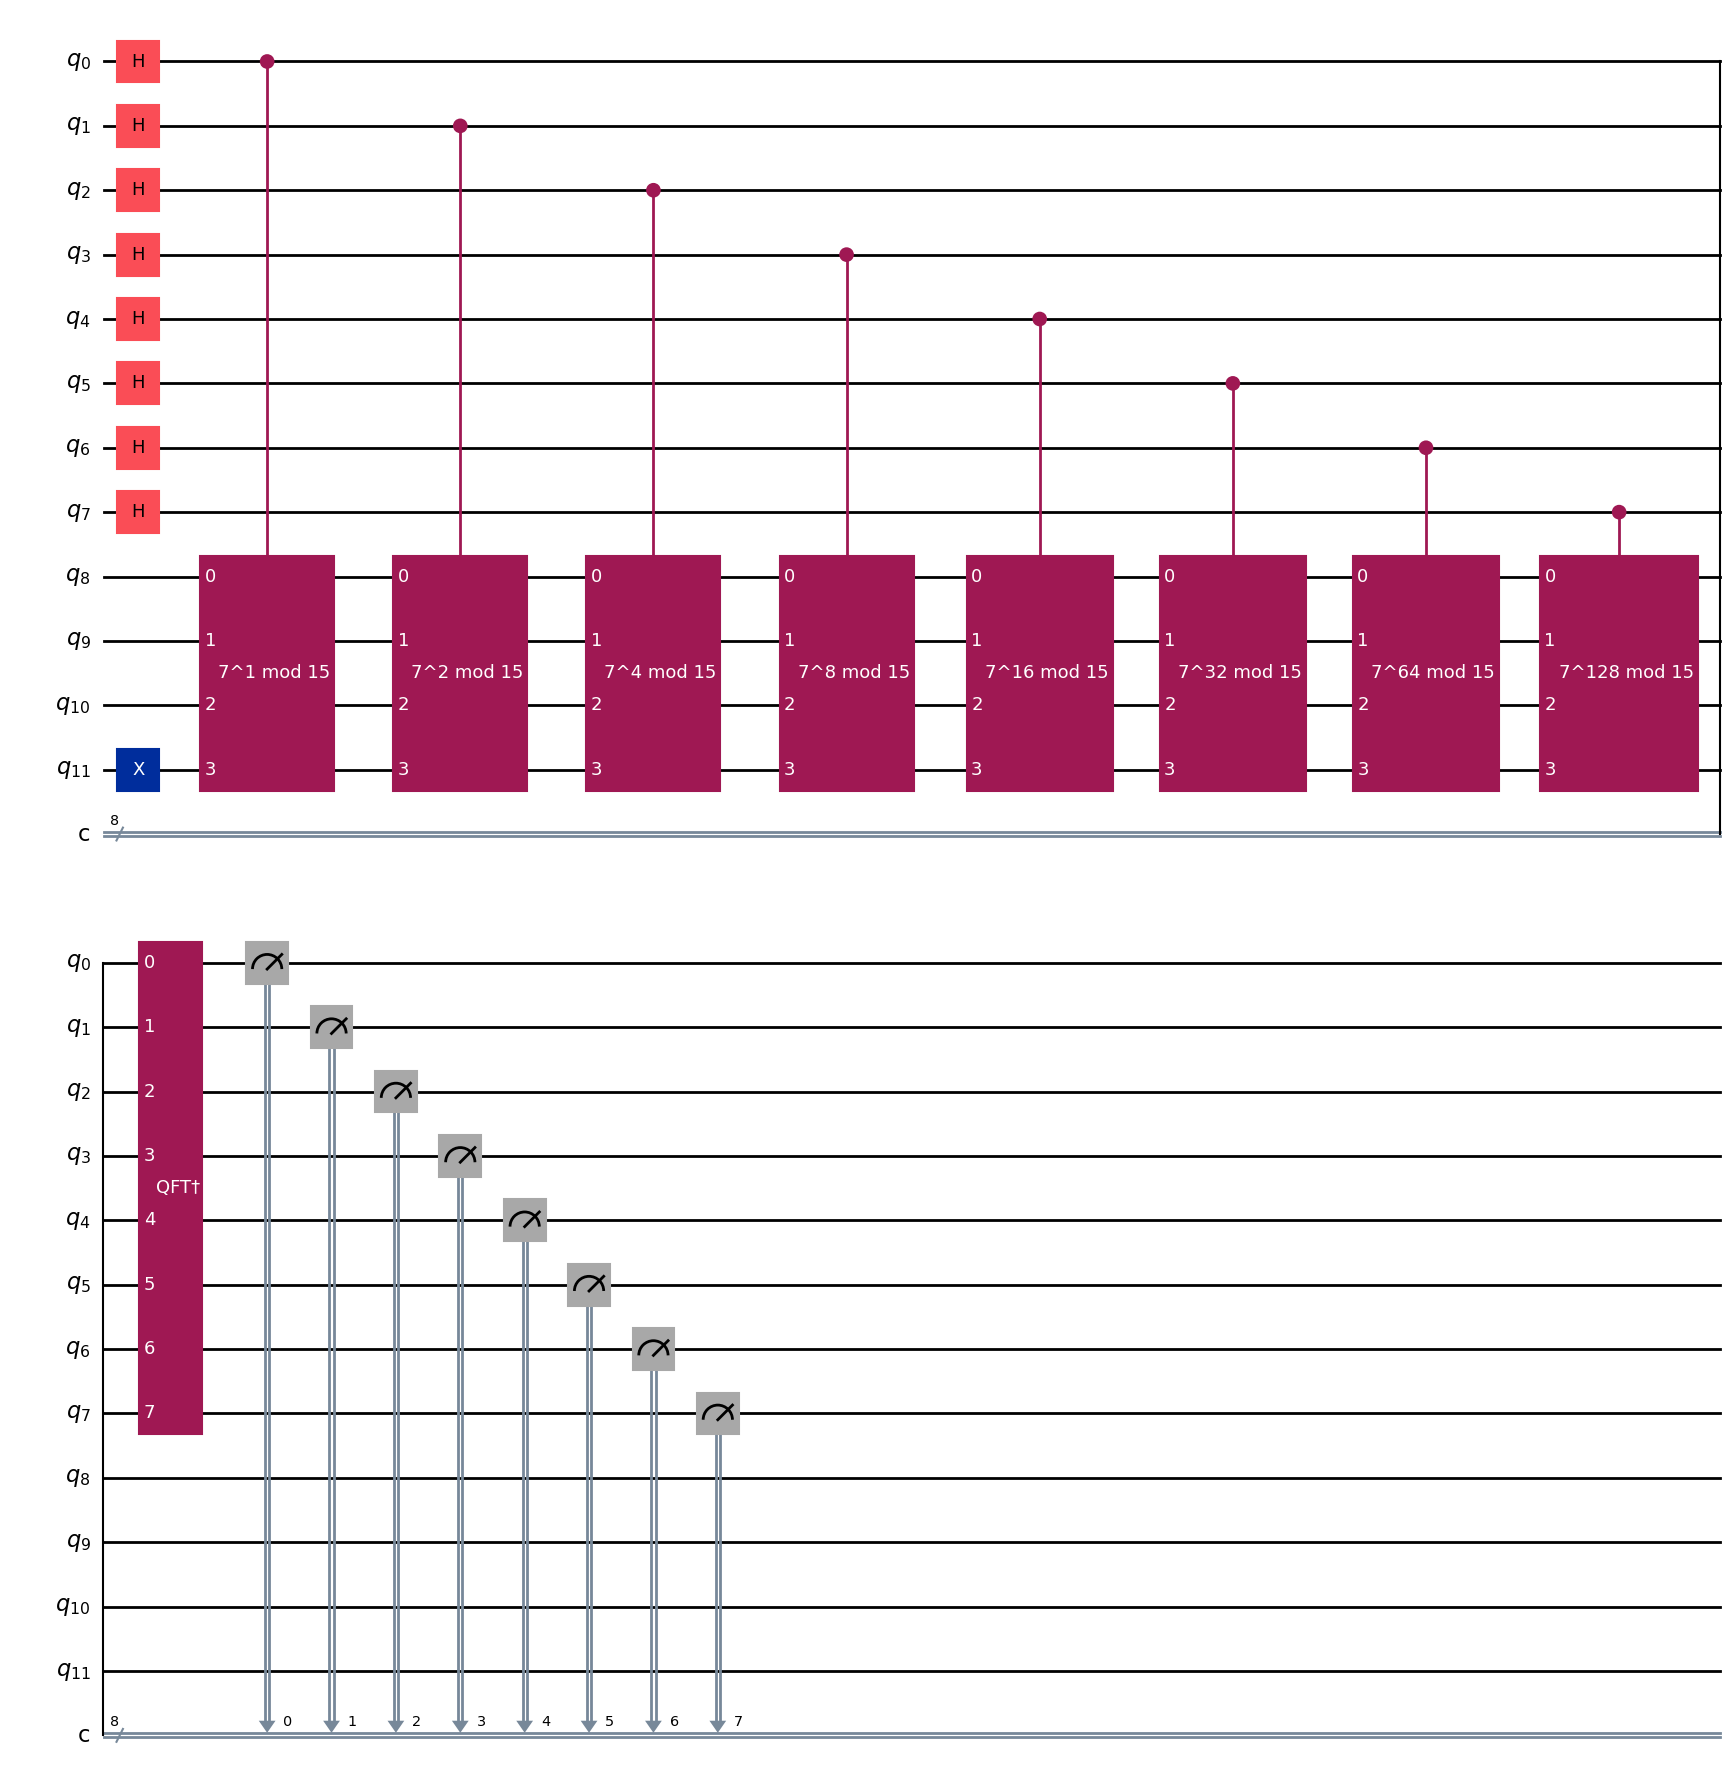

In [28]:
# create a circuit with n_count counting qubits + 4 qubits on which we apply U
qc = QuantumCircuit(n_count+4,n_count)  # we only measure the counting qubits

# initialize counting qubits in state +
for iq in range(n_count):
    qc.h(iq)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for iq in range(n_count):
    qc.append(c_amod15(a, 2**iq), 
             [iq] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('mpl')

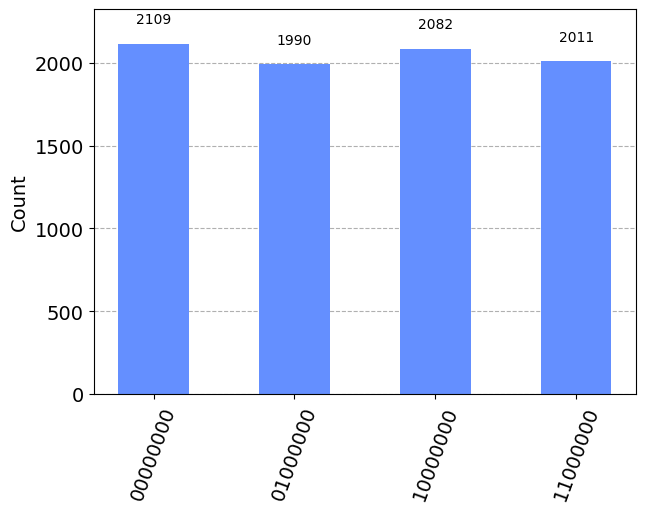

In [36]:
backend = QasmSimulator()
counts = backend.run(qc.decompose(), shots= 2048*4).result().get_counts()

plot_histogram(counts)

In [37]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0   01000000(bin) = 64(dec)   64/256 = 0.25
1  11000000(bin) = 192(dec)  192/256 = 0.75
2    00000000(bin) = 0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


#### We now use the Fraction module to turn a float into a fraction

In [38]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)  # turns into a fraction with maximum denominator 15
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for T"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for T
0   0.25      1/4            4
1   0.75      3/4            4
2   0.00      0/1            1
3   0.50      1/2            2


#### We get the correct period (4) in two out of 4 cases.  Shor's algorithm  fails if $s=0$ or if $s$ and $T$ are not co-primes. In this case we get a factor of $T$ instead of $T$. The simplest solution is to run again the algorithm until we find a satisfying result.

#### We can finally extract prime factors from the phases

In [39]:
def factors(a,T,N):
    fac = []
    fac.append( gcd(int(a**(T/2)-1),N) )
    fac.append( gcd(int(a**(T/2)+1),N) )
    return fac

In [40]:
 factors(a,4,15)

[3, 5]

In [26]:
gcd(50,15)

5

In [16]:
a=7
power=2

if a not in [2,4,7,8,11,13]:
    raise ValueError("'a' must be 2,4,7,8,11 or 13")
U = QuantumCircuit(4)

U.x(3)
for it in range(power):
    if a in [2,13]:
        U.swap(0,1)
        U.swap(1,2)
        U.swap(2,3)
    if a in [7,8]:
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
    if a in [4,11]:
        U.swap(1,3)
        U.swap(0,2)
    if a in [7,11,13]:
        for q in range(4):
            U.x(q)
#U.swap(0,3)
#U.swap(1,2)

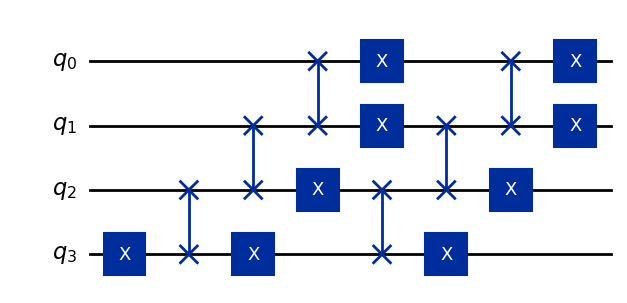

In [17]:
U.draw('mpl')

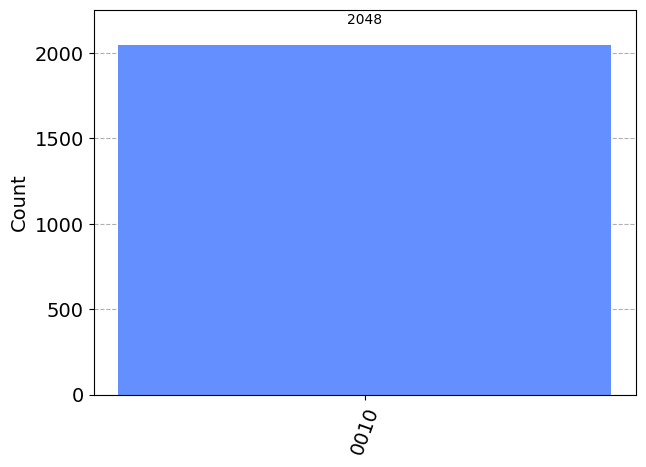

In [18]:
U.measure_all()

backend = QasmSimulator()
answer = backend.run(U.decompose(), shots= 2048).result().get_counts()

plot_histogram(answer)